1. run all models - extract val and test set
2. do mean of val and test set

In [1]:
import pandas as pd
from ogb.lsc import PygPCQM4MDataset, PCQM4MEvaluator
import numpy as np

from torch_geometric.data import DataLoader
from tqdm import tqdm
import torch

import os

Using backend: pytorch


In [2]:
"""
LOAD HYPERPARAMETERS
"""
# get args from main_gnn CLI
class Argument(object):
    name = "args"
    
args = Argument()
args.batch_size = 256
args.num_workers = 0
args.num_layers = 5
args.emb_dim = 600
args.drop_ratio = 0
args.graph_pooling = "sum"
args.device = 0

shared_params = {
    'num_layers': args.num_layers,
    'emb_dim': args.emb_dim,
    'drop_ratio': args.drop_ratio,
    'graph_pooling': args.graph_pooling
}

device = torch.device("cuda:" + str(args.device)) if torch.cuda.is_available() else torch.device("cpu")

## load data

In [3]:
"""
LOAD DATA
"""
### importing OGB-LSC
from ogb.lsc import PygPCQM4MDataset, PCQM4MEvaluator

dataset = PygPCQM4MDataset(root = 'dataset/')
split_idx = dataset.get_idx_split()

valid_loader = DataLoader(dataset[split_idx["valid"]], batch_size=args.batch_size, shuffle=False, num_workers = args.num_workers)
test_loader = DataLoader(dataset[split_idx["test"]], batch_size=args.batch_size, shuffle=False, num_workers = args.num_workers)
print(len(split_idx["train"]), len(split_idx["test"]), len(split_idx["valid"]))

3045360 377423 380670


In [4]:
def get_prediction(model, loader):
    y_true = []
    y_pred = []
    for step, batch in enumerate(tqdm(loader, desc="Iteration")):

        # put batch to cuda
        batch = batch.to(device)

        pred = model(batch)
        pred = pred.view(-1)    
        # collate prediction
        pred_np = pred.detach().cpu().numpy()
        y_pred.extend(pred_np)

        # collate label
        label = batch.y.detach().cpu().numpy()
        y_true.extend(label)
        
    return y_true, y_pred

## pygeom models

In [6]:
"""
gin-virtual-bayes-lastLayer
"""
from gnn import BayesianGNN

args.checkpoint_dir = "models/gin-virtual-bnn-lastLayer/checkpoint"

"""
LOAD Checkpoint data
"""
checkpoint = torch.load(os.path.join(args.checkpoint_dir, 'checkpoint.pt'))

gnn_name = "gin-virtual-bnn-lastLayer"
gnn_type = "gin"
virtual_node = True

model = BayesianGNN(gnn_type = gnn_type, virtual_node = virtual_node, last_layer_only=True, **shared_params).to(device)
model.load_state_dict(checkpoint["model_state_dict"], strict=True)
model.state_dict()
# set model to evaluation-only
model.eval()
print(gnn_name, checkpoint["best_val_mae"])

"""
get prediction for val
"""
y_true, y_pred = get_prediction(model, valid_loader)    
evaluator = PCQM4MEvaluator()
input_dict = {"y_true": torch.tensor(y_true), "y_pred": torch.tensor(y_pred)}
print("BayesianGNN", evaluator.eval(input_dict)["mae"])

# save results to dataframe
ginBNNDF = pd.DataFrame(zip(split_idx["valid"].cpu().tolist(), y_true, y_pred), columns=["molecule_idx", "label", "gin-pred"])

"""
get prediction for test
"""
_, ginBNN_test_pred = get_prediction(model, test_loader)    
ginBNN_test_pred = np.array(ginBNN_test_pred)
ginBNN_test_pred.shape

Iteration:   0%|                                                                      | 2/1487 [00:00<02:03, 12.04it/s]

gin-virtual-bnn-lastLayer 0.14056678116321564


Iteration: 100%|███████████████████████████████████████████████████████████████████| 1487/1487 [02:12<00:00, 11.22it/s]


BayesianGNN 0.14058490097522736


Iteration: 100%|███████████████████████████████████████████████████████████████████| 1475/1475 [02:16<00:00, 10.84it/s]


(377423,)

In [7]:
"""
gin-virtual
"""
from gnn import GNN

args.checkpoint_dir = "models/gin-virtual/checkpoint"

"""
LOAD Checkpoint data
"""
checkpoint = torch.load(os.path.join(args.checkpoint_dir, 'checkpoint.pt'))

gnn_name = "gin-virtual"
gnn_type = "gin"
virtual_node = True

model = GNN(gnn_type = gnn_type, virtual_node = virtual_node, **shared_params).to(device)
model.load_state_dict(checkpoint["model_state_dict"], strict=True)
model.state_dict()
# set model to evaluation-only
model.eval()
print(gnn_name, checkpoint["best_val_mae"])

"""
get prediction for val
"""
y_true, y_pred = get_prediction(model, valid_loader)    
evaluator = PCQM4MEvaluator()
input_dict = {"y_true": torch.tensor(y_true), "y_pred": torch.tensor(y_pred)}
print("BayesianGNN", evaluator.eval(input_dict)["mae"])

# save results to dataframe
ginDF = pd.DataFrame(zip(split_idx["valid"].cpu().tolist(), y_true, y_pred), columns=["molecule_idx", "label", "gin-pred"])

"""
get prediction for test
"""
_, gin_test_pred = get_prediction(model, test_loader)  
gin_test_pred = np.array(gin_test_pred)
gin_test_pred.shape

Iteration:   0%|                                                                      | 2/1487 [00:00<02:14, 11.03it/s]

gin-virtual 0.14212889969348907


Iteration: 100%|███████████████████████████████████████████████████████████████████| 1487/1487 [02:11<00:00, 11.32it/s]


BayesianGNN 0.14212889969348907


Iteration: 100%|███████████████████████████████████████████████████████████████████| 1475/1475 [02:14<00:00, 10.95it/s]


(377423,)

## load dgl models

In [8]:
# get valid result
ginDiffPoolDF = pd.read_csv("../pcqm4m-dgl/models/gin-virtual-diffpool/gin-virtual-diffPool-validResult.csv")

# get test result
with open('../pcqm4m-dgl/models/gin-virtual-diffpool/gin-virtual-diffpool-testResult.npy', 'rb') as f:
    ginDiffPool_test_pred = np.load(f)
    

In [9]:
# get valid result
ginDiffPool8DF = pd.read_csv("../pcqm4m-dgl/models/gin-virtual-diffpool-8/gin-virtual-diffPool-8-validResult.csv")


## ensembling

In [10]:
ginDF.head()

,molecule_idx,label,gin-pred
0,3045360,4.870838,4.860394
1,3045361,5.322547,5.343346
2,3045362,5.240913,4.994455
3,3045363,5.227307,5.107187
4,3045364,4.868117,5.044456


In [11]:
ginBNNDF.head()

,molecule_idx,label,gin-pred
0,3045360,4.870838,4.830795
1,3045361,5.322547,5.327971
2,3045362,5.240913,5.104687
3,3045363,5.227307,5.184566
4,3045364,4.868117,5.032032


In [12]:
ginDiffPoolDF.head()

,Unnamed: 0,molecule_idx,label,gin-diffpool-pred
0,0,3045360,4.870838,4.857602
1,1,3045361,5.322547,5.303278
2,2,3045362,5.240913,5.092427
3,3,3045363,5.227307,5.085762
4,4,3045364,4.868117,5.007533


In [13]:
"""
valid ensembling
"""
for name, pairs in [
    ["gin", (ginDF["gin-pred"], ginDF["gin-pred"])],
    ["gin-bnn", (ginBNNDF["gin-pred"], ginBNNDF["gin-pred"])],
    ["gin-diffpool", (ginDiffPoolDF["gin-diffpool-pred"], ginDiffPoolDF["gin-diffpool-pred"])],
    ["gin-diffpool-8", (ginDiffPool8DF["gin-diffpool-pred"], ginDiffPool8DF["gin-diffpool-pred"])],
    ["gin + gin-bnn", (ginDF["gin-pred"], ginBNNDF["gin-pred"])],
    ["gin + gin-diffpool", (ginDF["gin-pred"], ginDiffPoolDF["gin-diffpool-pred"])],
    ["gin + gin-diffpool-8", (ginDF["gin-pred"], ginDiffPool8DF["gin-diffpool-pred"])],
    ["gin-diffpool + gin-diffpool-8", (ginDiffPoolDF["gin-diffpool-pred"], ginDiffPool8DF["gin-diffpool-pred"])],
    ["gin-bnn + gin-diffpool", (ginBNNDF["gin-pred"], ginDiffPoolDF["gin-diffpool-pred"])],
    ["gin-bnn + gin-diffpool-8", (ginBNNDF["gin-pred"], ginDiffPool8DF["gin-diffpool-pred"])],
    ["gin + gin-bnn + gin-diffpool", (ginDF["gin-pred"], ginBNNDF["gin-pred"], ginDiffPoolDF["gin-diffpool-pred"])],
    ["gin + gin-bnn + gin-diffpool-8", (ginDF["gin-pred"], ginBNNDF["gin-pred"], ginDiffPool8DF["gin-diffpool-pred"])],
    ["gin-bnn + gin-diffpool + gin-diffpool8", (ginBNNDF["gin-pred"], ginDiffPoolDF["gin-diffpool-pred"], ginDiffPool8DF["gin-diffpool-pred"])],
    ["gin + gin-bnn + gin-diffpool + gin-diffpool8", (ginDF["gin-pred"], ginBNNDF["gin-pred"], ginDiffPoolDF["gin-diffpool-pred"], ginDiffPool8DF["gin-diffpool-pred"])],
]:

    mean_pred = np.mean(list(zip(*pairs)), axis=1)
    evaluator = PCQM4MEvaluator()
    input_dict = {"y_true": torch.tensor(y_true), "y_pred": torch.tensor(mean_pred)}
    print(name, evaluator.eval(input_dict)["mae"])


gin 0.14212890363096248
gin-bnn 0.14058490888759637
gin-diffpool 0.1370588209054448
gin-diffpool-8 0.14318594495303544
gin + gin-bnn 0.13507020261997804
gin + gin-diffpool 0.13387900794800642
gin + gin-diffpool-8 0.13646222980351494
gin-diffpool + gin-diffpool-8 0.1342922068366073
gin-bnn + gin-diffpool 0.13303067825681184
gin-bnn + gin-diffpool-8 0.13564762554268722
gin + gin-bnn + gin-diffpool 0.1318383292455719
gin + gin-bnn + gin-diffpool-8 0.13345387734737565
gin-bnn + gin-diffpool + gin-diffpool8 0.13214953615767608
gin + gin-bnn + gin-diffpool + gin-diffpool8 0.13140563695834476


In [14]:
# """
# test ensembling - and save
# """

# args.save_test_dir = "models/ensembling-gin-virtual-diffpool-bayesLastLayer"

# pairs = (ginBNN_test_pred, gin_test_pred, ginDiffPool_test_pred)
# ensemble_pred = np.mean(list(zip(*pairs)), axis=1)

# # evaluator.save_test_submission({'y_pred': ensemble_pred}, args.save_test_dir)


### create dataframe

In [116]:
""" collate results """
resultDF = pd.DataFrame(zip(ginDF["molecule_idx"], ginDF["label"], ginDF["gin-pred"], ginBNNDF["gin-pred"], ginDiffPoolDF["gin-diffpool-pred"]), 
             columns=["molecule_idx", "label", "pred_gin-virtual", "pred_gin-virtual-bnn-lastLayer", "pred_gin-virtual-diffpool"])
resultDF

,molecule_idx,label,pred_gin-virtual,pred_gin-virtual-bnn-lastLayer,pred_gin-virtual-diffpool
0,3045360,4.870838,4.860394,4.830795,4.857602
1,3045361,5.322547,5.343346,5.327971,5.303278
2,3045362,5.240913,4.994455,5.104687,5.092427
3,3045363,5.227307,5.107187,5.184566,5.085762
4,3045364,4.868117,5.044456,5.032032,5.007533
...,...,...,...,...,...
380665,3426025,5.347037,5.348439,5.480390,5.437385
380666,3426026,5.809631,5.551915,5.545543,5.531795
380667,3426027,5.064039,5.591818,5.336622,5.348639
380668,3426028,5.336153,5.545723,5.332222,5.347599


In [128]:
# get mean prediction of ensemble
resultDF["mean_pred"] = resultDF[["pred_gin-virtual", "pred_gin-virtual-bnn-lastLayer", "pred_gin-virtual-diffpool"]].mean(axis=1)

# get uncertainty
resultDF["std_pred"] = resultDF[["pred_gin-virtual", "pred_gin-virtual-bnn-lastLayer", "pred_gin-virtual-diffpool"]].std(axis=1)
resultDF["log_std_pred"] = np.log(resultDF["std_pred"])

# get error
resultDF["error"] = abs(resultDF["mean_pred"] - resultDF["label"])

# floored uncertainty
resultDF["floor_std_pred"] = resultDF["std_pred"].apply(lambda x: int(x*100)/100)

resultDF

,molecule_idx,label,pred_gin-virtual,pred_gin-virtual-bnn-lastLayer,pred_gin-virtual-diffpool,mean_pred,std_pred,log_std_pred,error,floor_std_pred
0,3045360,4.870838,4.860394,4.830795,4.857602,4.849597,0.016343,-4.113970,0.021240,0.01
1,3045361,5.322547,5.343346,5.327971,5.303278,5.324865,0.020213,-3.901409,0.002318,0.02
2,3045362,5.240913,4.994455,5.104687,5.092427,5.063856,0.060415,-2.806517,0.177057,0.06
3,3045363,5.227307,5.107187,5.184566,5.085762,5.125838,0.051975,-2.956984,0.101469,0.05
4,3045364,4.868117,5.044456,5.032032,5.007533,5.028007,0.018788,-3.974544,0.159890,0.01
...,...,...,...,...,...,...,...,...,...,...
380665,3426025,5.347037,5.348439,5.480390,5.437385,5.422071,0.067295,-2.698667,0.075034,0.06
380666,3426026,5.809631,5.551915,5.545543,5.531795,5.543084,0.010283,-4.577294,0.266547,0.01
380667,3426027,5.064039,5.591818,5.336622,5.348639,5.425693,0.143994,-1.937983,0.361654,0.14
380668,3426028,5.336153,5.545723,5.332222,5.347599,5.408515,0.119074,-2.128007,0.072362,0.11


In [134]:
resultDF[["error", "std_pred"]].corr()

,error,std_pred
error,1.000000,0.426394
std_pred,0.426394,1.000000


<AxesSubplot:ylabel='Frequency'>

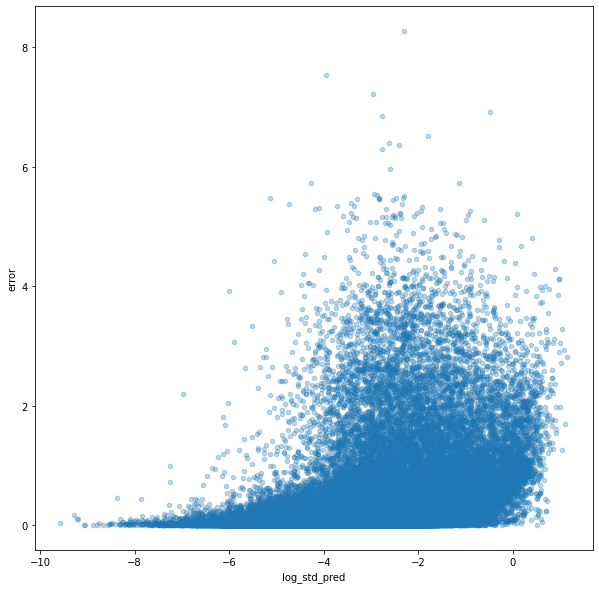

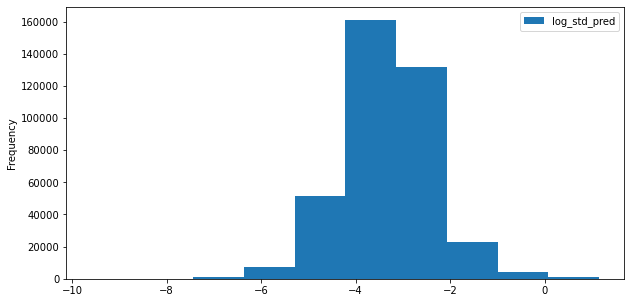

In [126]:
# uncertainty vs error
resultDF.plot.scatter("log_std_pred", "error", figsize=(10, 10), alpha=0.3)
# histogram of uncertainty distribution
resultDF[["log_std_pred"]].plot.hist(figsize=(10, 5))

<AxesSubplot:xlabel='mean_pred', ylabel='error'>

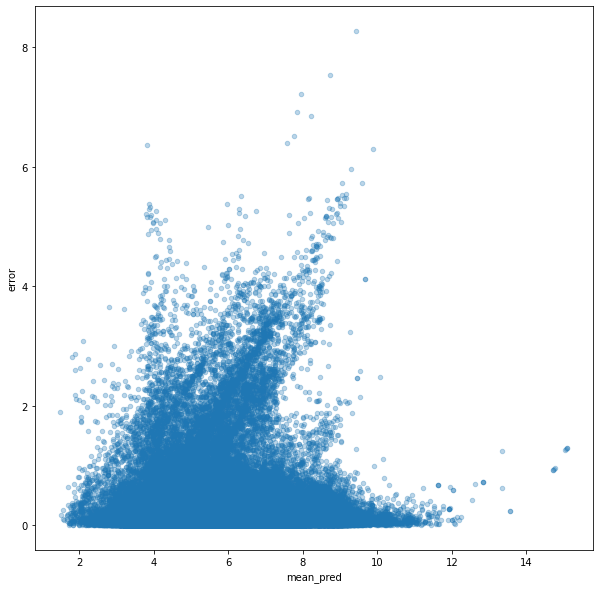

In [127]:
# mean-pred vs error
resultDF.plot.scatter("mean_pred", "error", figsize=(10, 10), alpha=0.3)

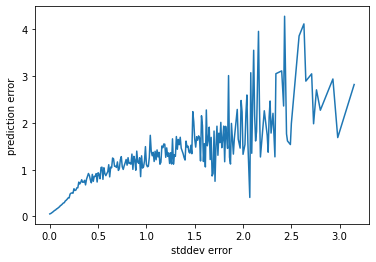

In [132]:
"""
evaluate per group
"""
evaluator = PCQM4MEvaluator()
errorPerStd = []
for floor_std_pred, rowDF in resultDF.groupby("floor_std_pred"):
    input_dict = {"y_true": torch.tensor(rowDF["label"].values), "y_pred": torch.tensor(rowDF["mean_pred"].values)}
    mae = evaluator.eval(input_dict)["mae"]
#     print(floor_std_pred, rowDF.shape[0], mae)
    errorPerStd.append([floor_std_pred, mae])

errorPerStd = np.array(errorPerStd)

plt.plot(errorPerStd[:, 0], errorPerStd[:, 1])
plt.xlabel("stddev error")
plt.ylabel("prediction error")
plt.show()

In [136]:
resultDF.to_csv("models/ensembling-gin-virtual-diffpool-bayesLastLayer/valid-pred-results.csv")